# Homework 3
## Problem 1
Formulation of the problem
\begin{equation*}
\begin{aligned}
& \underset{\text{A}_{12},\text{A}_{21}}{\text{min}}
& & \sum (P_{\text{predicted}} - P)^2 \\
\end{aligned}
\end{equation*}

estimation A12 and A21 is: tensor([1.9584, 1.6892], requires_grad=True)
final loss is: 0.6701940032990856


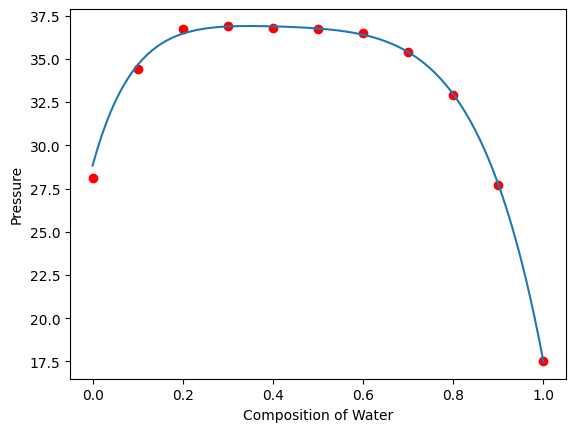

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt

X1 = np.arange(0, 1.1, 0.1)
X2 = np.flip(X1).copy()
X1 = torch.tensor(X1, requires_grad=False)
X2 = torch.tensor(X2, requires_grad=False)
a = np.array([[8.07131, 1730.63, 233.426], [7.43155, 1554.679, 240.337]])
T = 20
p_water = 10 ** (a[0, 0] - a[0, 1] / (T + a[0, 2]))
p_dioxane = 10 ** (a[1, 0] - a[1, 1] / (T + a[1, 2]))
p_data = np.array([[28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.7, 17.5]])

p_data = torch.tensor(p_data, requires_grad=False)

A = Variable(torch.tensor([1.0, 1.0]), requires_grad=True)


def pressure(A, x1, x2, p_w, p_dio):
    pressure_predicted = x1 * torch.exp(A[0] * (A[1] * x2 / (A[0] * x1 + A[1] * x2)) ** 2) * p_w + \
                         x2 * torch.exp(A[1] * (A[0] * x1 / (A[0] * x1 + A[1] * x2)) ** 2) * p_dio
    return pressure_predicted


def loss(predicted_pres, measured_pressure):
    error = (predicted_pres - measured_pressure) ** 2
    errorsum = error.sum()
    return errorsum


def inexact_line_search(function, gradient, initialpoint, slope):
    alpha = 1
    counterlinesearch = 0
    func_eval = function(pressure((initialpoint - alpha * gradient), X1, X2, p_water, p_dioxane), p_data)
    transposedgrad = torch.transpose(gradient, -1, 0)
    phi_eval = function(pressure(initialpoint, X1, X2, p_water, p_dioxane), p_data) - slope * torch.matmul(transposedgrad, gradient) * alpha
    while func_eval> phi_eval and counterlinesearch < 100:
        alpha = alpha / 2
        counterlinesearch += 1
        func_eval = function(pressure((initialpoint - alpha * gradient), X1, X2, p_water, p_dioxane), p_data)
        transposedgrad = torch.transpose(gradient, -1, 0)
        phi_eval = function(pressure(initialpoint, X1, X2, p_water, p_dioxane), p_data) - slope * torch.matmul(
            transposedgrad, gradient) * alpha
    xnew = initialpoint - alpha * gradient
    return alpha



tollerance = 1e-3
counter = 0
keepgoing = True

while counter < 100 and keepgoing == True:
    predicted = pressure(A, X1, X2, p_water, p_dioxane)
    squarederror = loss(predicted, p_data)

    squarederror.backward()
    alpha = inexact_line_search(loss, A.grad, A, 0.5)
    gradientnorm = torch.norm(A.grad)
    if gradientnorm < tollerance:
        keepgoing = False
    with torch.no_grad():
        A -= alpha * A.grad

        A.grad.zero_()
    counter += 1

print('estimation A12 and A21 is:', A)
print('final loss is:', squarederror.data.numpy())

x1predicted = np.linspace(0, 1, 100)
x2predicted = np.flip(x1predicted).copy()
ypredicted = pressure( A, torch.tensor(x1predicted), torch.tensor(x2predicted), p_water, p_dioxane)
ypredicted = ypredicted.detach().numpy()

fig, ax = plt.subplots()
ax.plot(x1predicted, ypredicted)
ax.scatter(X1.numpy(), p_data.numpy(), color='red')
plt.ylabel('Pressure')
plt.xlabel('Composition of Water')
plt.show()


## Problem 2
Bayesian Optimization
I will be using pyGPGO for my off the shelf bayesian solver. This solver finds the maximum within the region rather than the minimum, so I will alter the original function to find the final results
\begin{equation*}
\begin{aligned}
& \underset{\text{x}_{1},\text{x}_{2}}{\text{min}}
& & -\left(\left( 4 - 2.1x_1^2 + \frac{x_1^4}{3}\right)x_1^2 + x_1x_2 + (-4 + 4x_2^2)x^2_2 \right) \\
& S.T.
& & x_1 \in [-3,3] \ and \ x_2 \in [-2,2]
\end{aligned}
\end{equation*}


In [2]:
import numpy as np
def f(X1, X2):
    x1 = X1
    x2 = X2
    return 0 -( (4 - 2.1 * x1 **2 + x1 **4 / 3) * x1 **2 + x1 * x2 + (-4 + 4 * x2 **2) * x2 **2)


from pyGPGO.covfunc import squaredExponential
from pyGPGO.acquisition import Acquisition
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess

cov = squaredExponential()
gp = GaussianProcess(cov, optimize=True, usegrads=False)
acq = Acquisition(mode='ExpectedImprovement')
param = {'X1' : ('cont', [-3, 3]),
         'X2' : ('cont', [-2, 2])}

np.random.seed(20)
gpgo = GPGO(gp,acq,f,param)
gpgo.run(max_iter=30)
gpgo.getResult()

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.52878481 1.59085491]. 	  -17.29968374481291 	 -17.29968374481291
init   	 [2.34918438 1.26334991]. 	  -20.91583049569433 	 -17.29968374481291
init   	 [-2.78466249  0.76703033]. 	  -57.06253405225224 	 -17.29968374481291
1      	 [ 0.3346877 -2.       ]. 	  -47.75280667460338 	 -17.29968374481291
2      	 [-3. -2.]. 	  -162.89999999999998 	 -17.29968374481291
3      	 [ 3. -2.]. 	  -150.89999999999998 	 -17.29968374481291
4      	 [-0.85869534  2.        ]. 	  -48.223910609182184 	 -17.29968374481291
5      	 [3. 2.]. 	  -162.89999999999998 	 -17.29968374481291
6      	 [1.23589035 0.31689701]. 	  -2.4284791389037363 	 -2.4284791389037363
7      	 [1.23491808 0.31231767]. 	  -2.4319538571406882 	 -2.4284791389037363
8      	 [1.23502968 0.31282981]. 	  -2.4315688896865546 	 -2.4284791389037363
9      	 [-0.8327625  -0.25799745]. 	  -1.8415109483881422 	 -1.8415109483881422
10     	 [2.30005908 0.02934521]. 	  -11.805

(OrderedDict([('X1', -0.024989477828431205), ('X2', -0.06944067963168711)]),
 0.014962661425272096)

I after running the bayesian optimization using a gaussian estimation the results are as follows<br>
$ x_1 = -0.024989 \\ x_2 = -0.069444 \\ f(X) = 0.014962 $
